In [ ]:
# Retrieve data from the Materials Project API
# ref: https://docs.materialsproject.org/downloading-data/using-the-api/querying-data

import os
import dotenv

from emmet.core.utils import jsanitize
from monty.serialization import dumpfn

dotenv.load_dotenv()
MP_API_KEY = os.getenv("MP_API_KEY")

from mp_api.client import MPRester
from emmet.core.summary import HasProps

with MPRester(MP_API_KEY) as mpr:
    docs = mpr.summary.search(
        has_props = [HasProps.bandstructure], fields=['material_id', 'band_gap', 'builder_meta', 'nsites', 'elements', 'nelements', 'composition', 'composition_reduced', 'formula_pretty', 'formula_anonymous', 'chemsys', 'volume', 'density', 'density_atomic', 'symmetry', 'property_name', 'deprecated', 'deprecation_reasons', 'last_updated', 'origins', 'warnings', 'structure', 'task_ids', 'uncorrected_energy_per_atom', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'equilibrium_reaction_energy_per_atom', 'decomposes_to', 'xas', 'grain_boundaries', 'cbm', 'vbm', 'efermi', 'is_gap_direct', 'is_metal', 'es_source_calc_id', 'bandstructure', 'dos', 'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering', 'total_magnetization', 'total_magnetization_normalized_vol', 'total_magnetization_normalized_formula_units', 'num_magnetic_sites', 'num_unique_magnetic_sites', 'types_of_magnetic_species', 'k_voigt', 'k_reuss', 'k_vrh', 'g_voigt', 'g_reuss', 'g_vrh', 'universal_anisotropy', 'homogeneous_poisson', 'e_total', 'e_ionic', 'e_electronic', 'n', 'e_ij_max', 'weighted_surface_energy_EV_PER_ANG2', 'weighted_surface_energy', 'weighted_work_function', 'surface_anisotropy', 'shape_factor', 'has_reconstructed', 'possible_species', 'has_props', 'theoretical', 'database_IDs']
    )
    mpids = [doc.material_id for doc in docs]


sanitized_docs = jsanitize(docs)
dumpfn(sanitized_docs, "props_bandstructure.json.gz")


In [1]:
# Load the Materials Project dataset materials

import pandas as pd
from monty.serialization import loadfn

data = loadfn("../data/props_bandstructure.json.gz")    


In [2]:
df = pd.DataFrame(data)
df.head()
# unpack the "symmetry" data. Note there are probably other columns that need to be unpacked, but for now only handling this case
df[['crystal_system', 'symbol', 'number', 'point_group', 'symprec', 'version']] = df['symmetry'].apply(lambda x: pd.Series(x))

df = df.drop(columns=['version', 'symprec'])


In [3]:
import numpy as np

# somewhat arbitrarily, include materials that have e_ij_max values
df_numeric = df.select_dtypes(include='number')[df['e_ij_max'].notna()]
# drop columns that have more than 10% NaN values
df_numeric = df_numeric.dropna(how="any", axis=1)


# drop feature columns with correlation greater than 0.90
corr_matrix = df_numeric.corr().abs()
# select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]
df_numeric = df_numeric.drop(to_drop, axis=1)

corr_matrix.style.background_gradient(cmap='coolwarm', axis=None)


,nsites,nelements,volume,density,density_atomic,uncorrected_energy_per_atom,energy_per_atom,formation_energy_per_atom,energy_above_hull,band_gap,efermi,total_magnetization,total_magnetization_normalized_vol,total_magnetization_normalized_formula_units,num_magnetic_sites,num_unique_magnetic_sites,e_total,e_ionic,e_electronic,n,e_ij_max,number
nsites,1.000000,0.366767,0.783219,0.260152,0.287157,0.187161,0.204292,0.271287,0.043501,0.213928,0.190759,0.190119,0.039454,0.087400,0.262280,0.108160,0.024629,0.024538,0.024556,0.086836,0.052642,0.165694
nelements,0.366767,1.000000,0.212453,0.139452,0.269360,0.216913,0.238498,0.299917,0.063222,0.080190,0.090750,0.113010,0.074510,0.138167,0.156130,0.123218,0.033580,0.028459,0.034604,0.082168,0.003580,0.190862
volume,0.783219,0.212453,1.000000,0.153883,0.228417,0.110407,0.100015,0.062948,0.083812,0.038891,0.138571,0.088917,0.060595,0.000728,0.109747,0.022495,0.023519,0.026251,0.022814,0.053306,0.078998,0.079040
density,0.260152,0.139452,0.153883,1.000000,0.176590,0.081657,0.065411,0.063753,0.113297,0.405622,0.584022,0.083631,0.067478,0.079705,0.101640,0.088754,0.046804,0.065784,0.042351,0.156584,0.100078,0.221287
density_atomic,0.287157,0.269360,0.228417,0.176590,1.000000,0.592170,0.605333,0.428817,0.043189,0.332491,0.058300,0.145248,0.185119,0.147402,0.214006,0.152184,0.001659,0.006266,0.003437,0.065587,0.066170,0.171777
uncorrected_energy_per_atom,0.187161,0.216913,0.110407,0.081657,0.592170,1.000000,0.991404,0.595061,0.075002,0.263581,0.157180,0.124382,0.130723,0.123362,0.163102,0.104684,0.030356,0.046472,0.026611,0.009821,0.091838,0.085095
energy_per_atom,0.204292,0.238498,0.100015,0.065411,0.605333,0.991404,1.000000,0.635479,0.068047,0.254637,0.113099,0.172580,0.188720,0.173557,0.226285,0.163156,0.023920,0.041488,0.019873,0.025268,0.093867,0.116569
formation_energy_per_atom,0.271287,0.299917,0.062948,0.063753,0.428817,0.595061,0.635479,1.000000,0.171664,0.423289,0.225863,0.137097,0.125369,0.126566,0.180734,0.131220,0.022598,0.004999,0.026473,0.122207,0.060532,0.191174
energy_above_hull,0.043501,0.063222,0.083812,0.113297,0.043189,0.075002,0.068047,0.171664,1.000000,0.025554,0.058558,0.056169,0.090952,0.068369,0.070995,0.053188,0.006187,0.004667,0.006506,0.019201,0.022175,0.011308
band_gap,0.213928,0.080190,0.038891,0.405622,0.332491,0.263581,0.254637,0.423289,0.025554,1.000000,0.507949,0.149876,0.191684,0.192132,0.190552,0.215458,0.036694,0.042199,0.035313,0.163743,0.040422,0.098992


In [4]:
# retrive categorical labels of the data 

df_categorical = df.iloc[df_numeric.index].select_dtypes(include=['object'])
df_categorical = df_categorical[['formula_anonymous', 'chemsys', 'ordering', 'crystal_system', 'symbol', 'point_group']]


In [5]:
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split, KFold

from tensorflow import keras
from tensorflow.keras import callbacks, layers, regularizers


In [12]:
materials = pd.merge(df_numeric, df_categorical, left_index=True, right_index=True)

X = materials
y = materials.pop('band_gap')  # target property

scaler = MinMaxScaler()
y = scaler.fit_transform(np.array(y).reshape(-1, 1))


preprocessor = make_column_transformer(
    (StandardScaler(),
     make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(sparse_output=False),
     make_column_selector(dtype_include=object)),
)

X = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


input_shape = [X.shape[1]]
print("Input shape: {}".format(input_shape))


Input shape: [2374]


In [7]:
X.shape


(2536, 2374)

In [8]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.2),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dense(256, activation='swish'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.2),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dense(128, activation='sigmoid'),
    layers.Dense(1),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
from tensorflow.keras.optimizers.legacy import Adam

# set the learning rate to 0.001
optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='mae',
)


In [20]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True)

# Initialize a list to store the MSE for each fold
mse_scores = []
best_mse = float('inf')
best_model = None

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the model on the training data
    history = model.fit(X_train, y_train, validation_data=[X_test, y_test], epochs=15, batch_size=32, verbose=0, callbacks=[early_stopping])

    # Evaluate the model on the test data
    mse = model.evaluate(X_test, y_test, verbose=0)

    # Keep track of the best model
    if mse < best_mse:
        best_mse = mse
        best_model = model.get_weights()

    # Append the MSE to the list of MSE scores
    mse_scores.append(mse)

# Load the best model weights
model.set_weights(best_model)

average_mse = np.mean(mse_scores)
print(average_mse, mse_scores)


0.01759692933410406 [0.01817912422120571, 0.01764051616191864, 0.015045764856040478, 0.018129797652363777, 0.0189894437789917]


Minimum validation loss: 0.015192778781056404


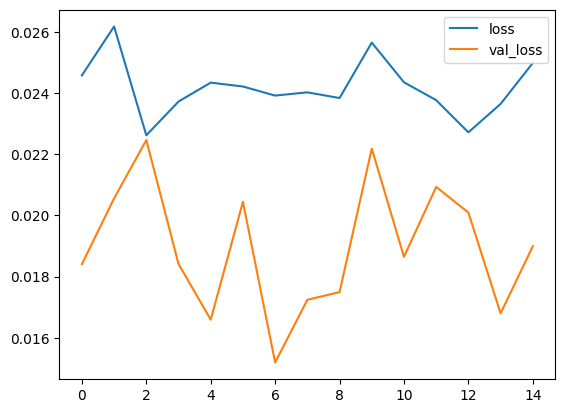

In [21]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))


80/80 [==============================] - 0s 690us/step


Text(0, 0.5, 'Predicted Values')

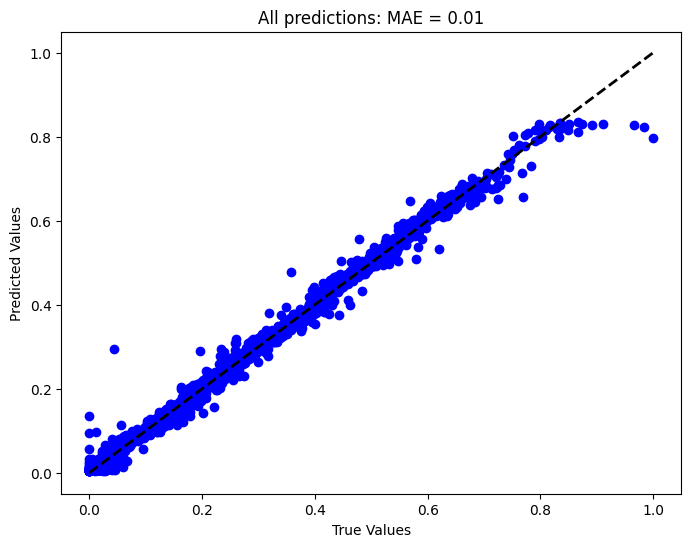

In [28]:
train_predictions = model.predict(X)
mae_train = np.mean(np.abs(train_predictions - y))


fig, ax = plt.subplots(figsize=(8, 6), ncols=1, nrows=1)
ax.scatter(y, train_predictions, color='b', label='Train Set')
ax.set_title(f'All predictions: MAE = {mae_train:.2f}')

ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
